In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
from datetimerange import DateTimeRange
from tqdm import tqdm_notebook as tqdm
import traceback

In [34]:
df = pd.read_csv("data/genera passaggi per python.txt", encoding="latin")
df = df.drop(["log_start","log_end"],axis=1)
df.head(20)

,MAC Address,tempo_log,AP Name,log_startv,log_endv,area
0,00:00:36:75:f5:36,10,Aule-B55-01-PortineriaP1,2018-11-09T15:58:00,2018-11-09T16:08:39,Polo Fibonacci
1,00:00:48:dd:35:b7,606,MED-SC-Ed2-Neonatologia-P1,2018-11-12T05:07:00,2018-11-12T15:13:56,Ospedale Santa Chiara
2,00:00:48:dd:35:b7,1227,MED-SC-Ed2-Neonatologia-P1,2018-11-06T11:40:00,2018-11-07T08:07:54,Ospedale Santa Chiara
3,00:00:6a:4a:28:6a,7,VET-B22-Aula_E,2018-11-07T07:58:00,2018-11-07T08:05:33,Dipartimento di Scienze Veterinarie
4,00:00:b6:ff:50:b6,5,CIS_MED-Ed30C_A_S1-S2_Cor_PT_Est,2018-11-06T10:04:00,2018-11-06T10:09:21,Ospedale di Cisanello
5,00:03:7f:c2:00:43,5,AP_MensaPraticelli,2018-11-06T18:34:00,2018-11-06T18:39:03,Residenza I Praticelli
6,00:03:ab:db:1d:85,5,FARM_AP_Minutolo,2018-11-11T15:57:00,2018-11-11T16:02:22,Dipartimento di Farmacia
7,00:03:ac:19:2e:39,96,ECO_AulaB,2018-11-07T06:30:00,2018-11-07T08:06:00,Dipartimento di Economia
8,00:03:ac:19:2e:39,6,PEA-Aula_L1Ext,2018-11-12T10:56:00,2018-11-12T11:02:23,Dipartimento di Economia
9,00:03:ac:19:2f:c6,10,PalCongressi_RoomE,2018-11-10T12:00:00,2018-11-10T12:10:52,Palazzo Congressi


# Data Understanding

### Capire come sono distribuiti i tempi di connessione.

Posso scartare overlapping non significativi (troppo corti) ?
(dare la definizione di "corti")

Devo considerare il tempo di overlapping in correlazione con il tempo di connesssione?<br>
Oppure i tempi di overlapping sono distribuiti come i tempi di connessione? 

In [10]:
import datetime
def calcolasecondi (range1,range2):
    inter = range1.intersection(range2)
    estremo1 = str(inter).split(" - ")[0]
    estremo2 = str(inter).split(" - ")[1]
    return ((np.datetime64(estremo2) - np.datetime64(estremo1)) / np.timedelta64(1, 's'))

In [92]:
AP = "VET-B22-Aula_E" #"CIS_MED_Ed30C_S1-S2_Corr_PT_Int"

In [101]:
# genera lista con tutti i tempi di overlapping di un singolo access point (AP)

different_AP = [AP] #set(df["AP Name"])
overlapping_time = []
for AP in different_AP:
    df_AP = df[df["AP Name"]==AP].values
    for i in tqdm(range(0,len(df_AP)-1)):
        for j in range(i+1,len(df_AP)):
            try:
                datarange1= DateTimeRange(df_AP[i][3],df_AP[i][4])
                datarange2= DateTimeRange(df_AP[j][3],df_AP[j][4])
                is_inters = datarange1.is_intersection(datarange2)
                if (is_inters):
                    assert(df_AP[i][0] != df_AP[j][0])
                    overlapping_time.append(calcolasecondi(datarange1,datarange2))
            except ValueError:
                print ("problemi con le date")
                print (df_AP[i][2],df_AP[i][3])
                print (df_AP[j][2],df_AP[j][3])
                traceback.print_exc()
                break

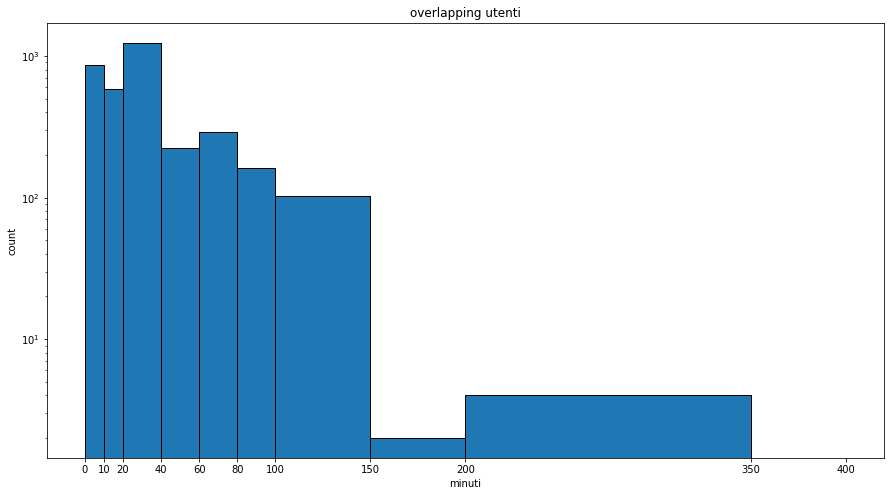

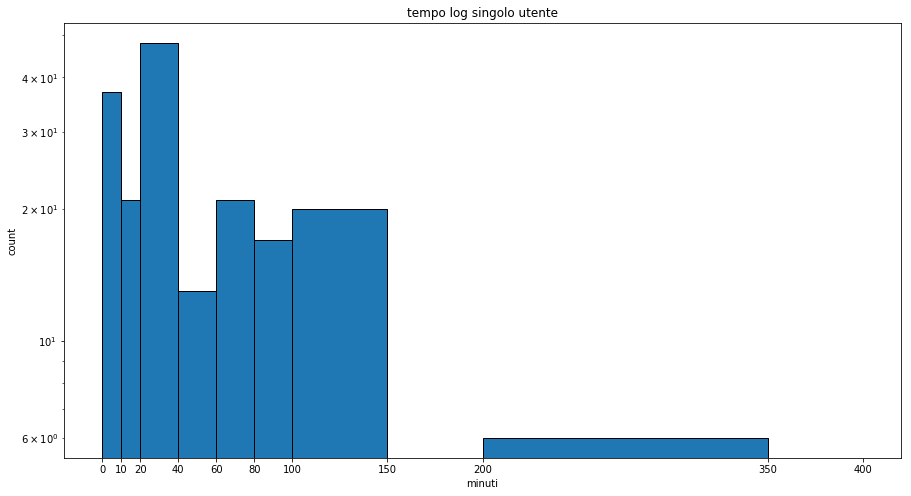

In [102]:
# per specifico AP,
#   plotta:
#   - barchart dei tempi di overlap (tutte le coppie di utenti)
#   - barchart dei tempi di connessione (utenti presi singolarmente)

plt.figure(figsize = (15,8))
bins=[0,10,20,40,60,80,100,150,200,350,400]
plt.title("overlapping utenti")
plt.ylabel("count")
plt.xlabel("minuti")
plt.hist(np.array(overlapping_time)/60.0, bins=bins, log=True, ec='black')
plt.xticks(bins)

plt.show()


plt.figure(figsize = (15,8))
plt.title("tempo log singolo utente")
plt.ylabel("count")
plt.xlabel("minuti")
plt.hist(df[df["AP Name"]==AP]["tempo_log"], bins=bins, log=True, ec='black')
plt.xticks(bins)

plt.show()



Corto vuol dire < 20 minuti <br>


# Social Network

###  Rete di prossimità

* nodi: gli utenti
* archi: se due utenti sono stati connessi allo stesso AP contemporaneamente per più di N minuti (N =~ 20, da perfezionare)

In [37]:
df[df["area"]=="Dipartimento di Chimica"]

,MAC Address,tempo_log,AP Name,log_startv,log_endv,area
330,00:22:fa:06:70:24,114,DCCI-B74-Corr1B-1C,2018-11-06T06:43:00,2018-11-06T08:37:55,Dipartimento di Chimica
488,00:26:bb:0b:a6:3b,17,DCCI-B74-00-Biblioteca,2018-11-12T14:09:00,2018-11-12T14:26:02,Dipartimento di Chimica
687,00:5a:13:2f:1c:e6,5,DCCI-B74-00-AulaF,2018-11-12T13:26:00,2018-11-12T13:31:25,Dipartimento di Chimica
690,00:5a:13:2f:20:16,21,DCCI-B74-00-Biblioteca,2018-11-06T08:22:00,2018-11-06T08:43:20,Dipartimento di Chimica
691,00:5a:13:2f:20:16,8,DCCI-B74-00-AulaMagna,2018-11-12T15:08:00,2018-11-12T15:16:19,Dipartimento di Chimica
819,00:61:71:76:e9:a4,8,DCCI-B74-01-Corr1A-1D,2018-11-12T15:08:00,2018-11-12T15:16:19,Dipartimento di Chimica
820,00:61:71:76:e9:a4,5,DCCI-B74-00-Biblioteca,2018-11-06T08:27:00,2018-11-06T08:32:24,Dipartimento di Chimica
893,00:6d:52:30:62:74,137,DCCI-B74-00-Biblioteca,2018-11-12T12:58:00,2018-11-12T15:15:13,Dipartimento di Chimica
1053,00:71:cc:6d:8a:06,77,DCCI-B74-00-Biblioteca,2018-11-09T15:58:00,2018-11-09T17:15:34,Dipartimento di Chimica
1189,00:9a:cd:6a:23:20,6,DCCI-B74-00-Bar,2018-11-09T12:26:00,2018-11-09T12:32:10,Dipartimento di Chimica


In [38]:
tempoMinimo = 20.0 * 60.0

selected_area = ["Dipartimento di Chimica"]#set(df["AP Name"])

for area in selected_area:
    archi = {}
    df_area = df[df["area"]==area].values
    for i in tqdm(range(0,len(df_area)-1)):
        for j in range(i+1,len(df_area)):
            try:
                datarange1= DateTimeRange(df_area[i][3],df_area[i][4])
                datarange2= DateTimeRange(df_area[j][3],df_area[j][4])
                is_inters = datarange1.is_intersection(datarange2)
                if (is_inters):
                    assert(df_area[i][0] != df_area[j][0])
                    overlapping = calcolasecondi(datarange1,datarange2)
                    if (overlapping >= tempoMinimo):
                        assert(df_area[i][0] != df_area[j][0])
                        coppia = (df_area[i][0],df_area[j][0])
                        if (coppia in archi): archi[coppia] += 1
                        else: archi[coppia] = 1
            except ValueError:
                print ("problemi con le date")
                print (df_area[i][2],df_area[i][3])
                print (df_area[j][2],df_area[j][3])
                traceback.print_exc()
                break

In [39]:
archi_graph = []
for elem in archi:
    single_arch = (elem[0],elem[1],{"weight": archi[elem]})
    archi_graph.append(single_arch)

In [40]:
import networkx as nx
G = nx.Graph()
G.add_edges_from(archi_graph)

In [41]:
G.number_of_edges()

20919

In [42]:
G.number_of_nodes()

345

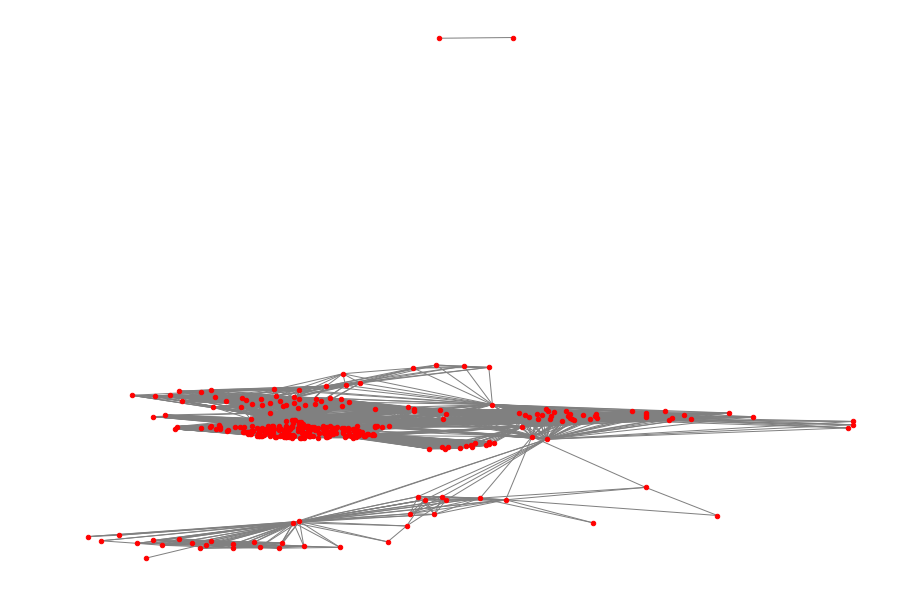

In [43]:

plt.figure(figsize=(12,8))
nx.draw(G, node_size=20, edge_color='grey')
plt.show()